In [174]:
from pathlib import Path
from copy import deepcopy
from typing import cast, List, Literal, TypedDict

import numpy as np
import pandas as pd
from ulid import ULID
from scipy import stats               
import matplotlib.pyplot as plt
from google.api_core.datetime_helpers import DatetimeWithNanoseconds

DF_PATH = Path('data/final_df_250603.csv')
assert DF_PATH.exists(), f"Data file not found at {DF_PATH}"

In [2]:
EventType = Literal["new-session", "interaction"]

class EventData(TypedDict):
    correctTag: str 
    draggedTag: str
    eventType: EventType
    orderingId: int
    sessionId: str
    targetWord: str

class Word(TypedDict):
    word: str
    tag: str

class SessionData(TypedDict):
    eventType: EventType
    serie: str
    sessionId: str
    startTime: DatetimeWithNanoseconds
    words: List[Word]

In [367]:
SESSION_ID = 'rZvC0RiJEH'
# SESSION_ID = 'SX-gw0Y4ER'

In [3]:
new_session_df = pd.read_csv('data/new_session_data_250603.csv')

def cast_words(words: str) -> List[Word]:
    assert isinstance(words, str), f"Expected str, got {type(words)}"
    words_ = cast(List[Word], eval(words))
    return words_

new_session_df['words'] = new_session_df['words'].apply(cast_words)

new_session_df['words_attempts'] = new_session_df['words'].map(
    lambda word_list: {f"{word['tag']}|{word['word']}|{ULID()}":1 for word in word_list}
)

new_session_df.head(3)

# display(new_session_df[new_session_df['sessionId'] == SESSION_ID]['words_attempts'].values[0])
# ' '.join([w['word'] for w in new_session_df[new_session_df['sessionId'] == SESSION_ID]['words'].values[0]])

,startTime,serie,words,eventType,sessionId,words_attempts
0,2025-05-27 00:49:01.547000+00:00,5-ensino-fundamental,"[{'tag': 'Verbo', 'word': 'Será'}, {'tag': 'Co...",new-session,xqEk5ZfKaG,"{'Verbo|Será|01JX8VKANF2TSK07BGS75XVC1P': 1, '..."
1,2025-05-27 01:01:42.509000+00:00,5-ensino-fundamental,"[{'tag': 'Nome Próprio', 'word': 'Ufa'}, {'tag...",new-session,uQY36KP907,{'Nome Próprio|Ufa|01JX8VKANF6J6CG6B3R1NGCAHR'...
2,2025-05-27 11:11:54.325000+00:00,6-ensino-fundamental,"[{'tag': 'Artigo', 'word': 'A'}, {'tag': 'Subs...",new-session,X2RK9EgWWZ,"{'Artigo|A|01JX8VKANFPJKCC1T4ZBSE1624': 1, 'Su..."


<Axes: title={'center': 'Number of sessions per serie'}, xlabel='serie'>

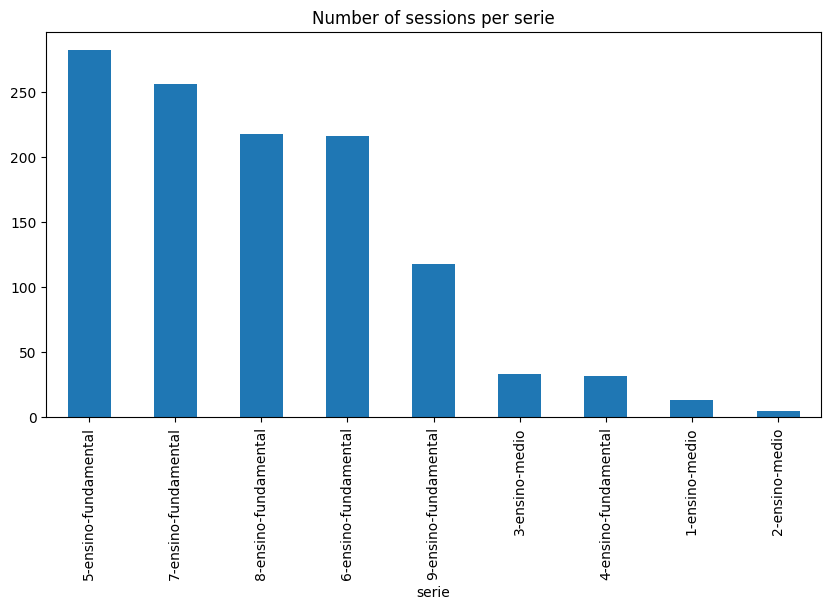

In [84]:
new_session_df['serie'].value_counts().plot(kind='bar', figsize=(10, 5), title='Number of sessions per serie')

In [369]:
# df = pd.read_csv(DF_PATH)
# df['sessionId'].sample()

In [ ]:
df = pd.read_csv('data/interaction_data_250603.csv')
SAMPLE_ID = df['sessionId'].sample().values[0]
print(f"Sample sessionId: {SAMPLE_ID}")

In [80]:
df[df['sessionId'] == SAMPLE_ID][['correctTag', 'draggedTag']]

,correctTag,draggedTag
6057,Pontuação,Pontuação
6070,Verbo,Substantivo
6083,Substantivo,Preposição+Artigo
6087,Substantivo,Substantivo
6093,Pronome,Verbo
6120,Verbo,Substantivo
6130,Verbo,Verbo
6159,Substantivo,Pronome
6163,Substantivo,Preposição+Artigo
6181,Artigo,Verbo


In [ ]:
def create_words_attempts_list(words_attempts: dict) -> dict:
    words_attempts_dict = dict()

    i:str
    for i in list(words_attempts.keys()):
        ud, word, ulid = i.split('|')
        try:
            words_attempts_dict[f'{ud}|{word}'].append(ulid)
        except KeyError:
            words_attempts_dict[f'{ud}|{word}'] = [ulid]
    return words_attempts_dict

def fill_words_attempts(words_attempts_serie: pd.Series):
    aux_idx = -1
    words_attempts = deepcopy(words_attempts_serie['words_attempts'])
    session_id = words_attempts_serie['sessionId']
    gp = df[df['sessionId'] == session_id].copy()

    words_attempts_dict = create_words_attempts_list(words_attempts)

    for _, row in gp.iterrows():
        assert row['orderingId'] > aux_idx # garante que ta ordem crescente
        aux_idx = row['orderingId']
        k = f"{row['correctTag']}|{row['targetWord']}"
        assert k in words_attempts_dict, f"Key {k} not found in words_attempts"
        if row['draggedTag'] != row['correctTag']:
            words_attempts[f'{k}|{words_attempts_dict[k][0]}'] += 1
        else:
            words_attempts_dict[k].pop(0)

    for k,v in words_attempts_dict.items():
        if len(v) > 0:
            while(v):
                ulid_ = v.pop(0)
                words_attempts[f'{k}|{ulid_}'] -= 1

    return words_attempts
    
new_session_df['words_attempts_fill'] = new_session_df[['words_attempts', 'sessionId']].apply(fill_words_attempts, axis=1)

In [7]:
def count_attempts(words_attempts_fill: dict):
    zero_counter = 0
    less_zero_counter = 0
    for k,v in words_attempts_fill.items():
        if v < 0:
            less_zero_counter += 1
        elif v == 0:
            zero_counter += 1

    return False if (zero_counter > 2) or (less_zero_counter > 2) else True

In [8]:
filter_attempts = new_session_df['words_attempts_fill'].apply(count_attempts)
new_session_df = new_session_df[filter_attempts].reset_index(drop=True)

In [86]:
def get_tags_statistics(wa_series: pd.Series):
    counter_dict = {
        'Adjetivo': [],
        'Preposição': [],
        'Advérbio': [],
        'Conjunção Coordenativa': [],
        'Artigo': [],
        'Interjeição': [],
        'Substantivo': [],
        'Numeral': [],
        'Pronome': [],
        'Nome Próprio': [],
        'Pontuação': [],
        'Conjunção Subordinativa': [],
        'Preposição+Artigo': [],
        'Preposição+Pronome': [],
        'Verbo': [],
        'Verbo Auxiliar': [],
        'Verbo de Ligação': [],
        'Verbo Passivo': [],
        'Verbo+Pronome': [],
    }
    
    for d in wa_series:
        for k, v in d.items():
            ud, _, _ = k.split('|')
            assert ud in counter_dict, f"Unknown UD: {ud}"
            counter_dict[ud].append(v)

    return counter_dict

stats_df = new_session_df.groupby('serie')['words_attempts_fill'].apply(get_tags_statistics).reset_index()

In [87]:
stats_df['mean_attempts'] = stats_df['words_attempts_fill'].apply(np.mean)
stats_df.fillna(0, inplace=True)

/home/antonio/venvs/pln-api-py31110/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/venvs/pln-api-py31110/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [88]:
em = ['1-ensino-medio', '2-ensino-medio', '3-ensino-medio', '4-ensino-fundamental']
stats_df = stats_df[~stats_df['serie'].isin(em)].reset_index(drop=True)

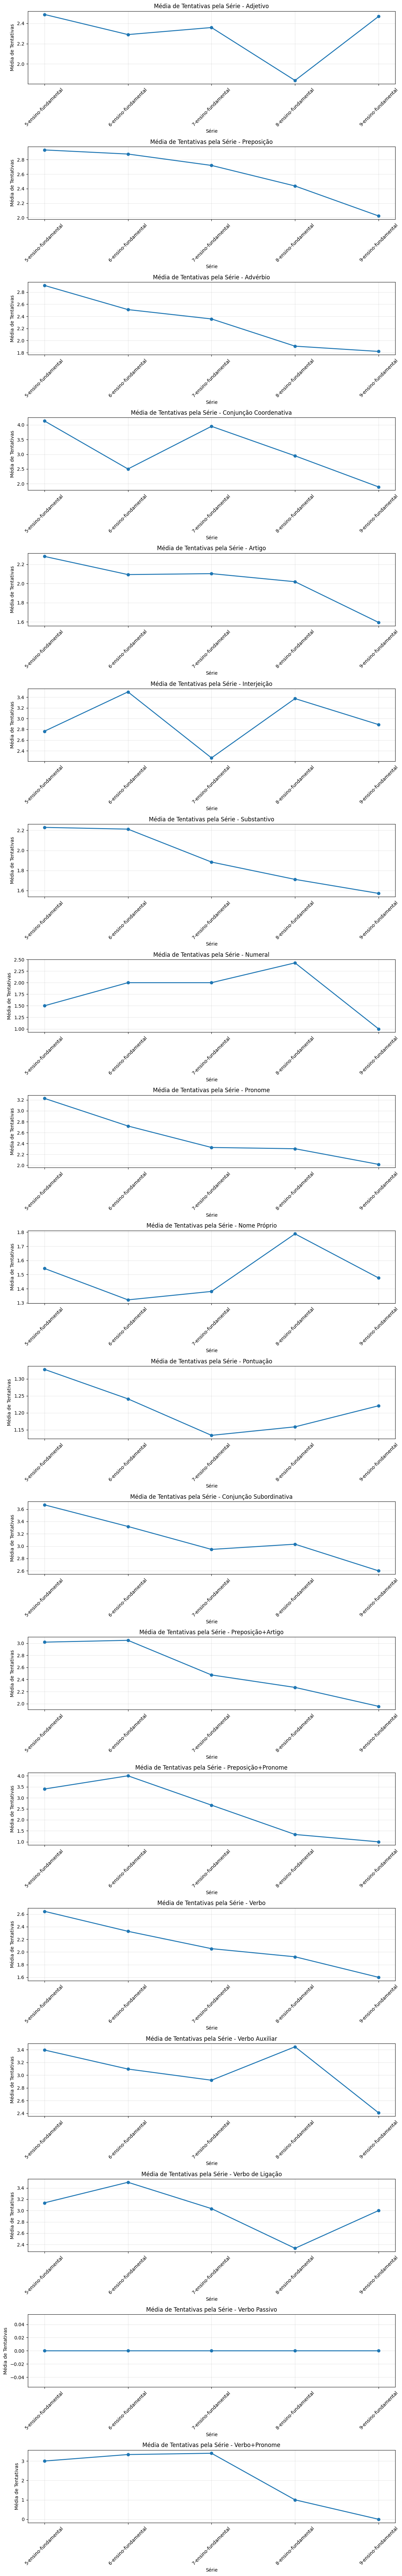

In [123]:
# First, we need to expand the stats_df to get the proper structure
stats_expanded = stats_df.explode('words_attempts_fill').reset_index(drop=True)

# Get unique tags
unique_tags = stats_df['level_1'].unique()

# Create subplots - one for each tag
fig, axes = plt.subplots(len(unique_tags), 1, figsize=(12, 4 * len(unique_tags)))

# Handle case where there's only one tag
if len(unique_tags) == 1:
    axes = [axes]

for i, tag in enumerate(unique_tags):
    tag_data = stats_df[stats_df['level_1'] == tag][['serie', 'mean_attempts']]
    if not tag_data.empty:
        axes[i].plot(tag_data['serie'], tag_data['mean_attempts'], marker='o', linewidth=2, markersize=6)
        axes[i].set_xlabel('Série')
        axes[i].set_ylabel('Média de Tentativas')
        axes[i].set_title(f'Média de Tentativas pela Série - {tag}')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        
        # Save each axis as a separate PNG
        fig_single = plt.figure(figsize=(16, 5))
        ax_single = fig_single.add_subplot(111)
        ax_single.plot(tag_data['serie'], tag_data['mean_attempts'], marker='o', linewidth=2, markersize=6)
        ax_single.set_xlabel('Série')
        ax_single.set_ylabel('Média de Tentativas')
        ax_single.set_title(f'Média de Tentativas pela Série - {tag}')
        ax_single.tick_params(axis='x', rotation=45)
        ax_single.grid(True, alpha=0.3)
        
        # Clean filename by replacing special characters
        filename = f"figs/mean_attempts_{tag.replace('/', '_').replace('+', '_').replace(' ', '_')}.png"
        fig_single.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig_single)

plt.tight_layout()
plt.show()

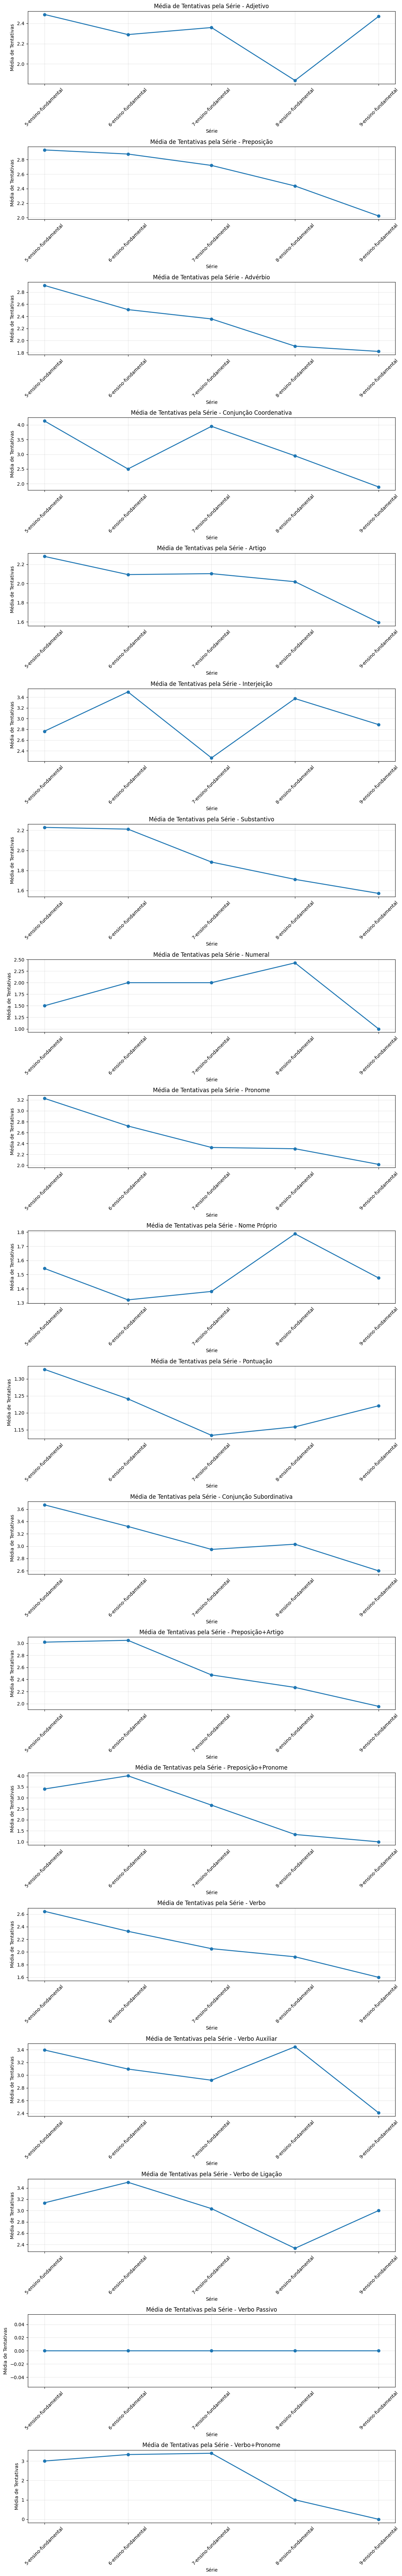

In [ ]:
# First, we need to expand the stats_df to get the proper structure
stats_expanded = stats_df.explode('words_attempts_fill').reset_index(drop=True)

# Get unique tags
unique_tags = stats_df['level_1'].unique()

# Create subplots - one for each tag
fig, axes = plt.subplots(len(unique_tags), 1, figsize=(12, 4 * len(unique_tags)))

# Handle case where there's only one tag
if len(unique_tags) == 1:
    axes = [axes]

for i, tag in enumerate(unique_tags):
    tag_data = stats_df[stats_df['level_1'] == tag][['serie', 'mean_attempts']]
    if not tag_data.empty:
        axes[i].plot(tag_data['serie'], tag_data['mean_attempts'], marker='o', linewidth=2, markersize=6)
        axes[i].set_xlabel('Série')
        axes[i].set_ylabel('Média de Tentativas')
        axes[i].set_title(f'Média de Tentativas pela Série - {tag}')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

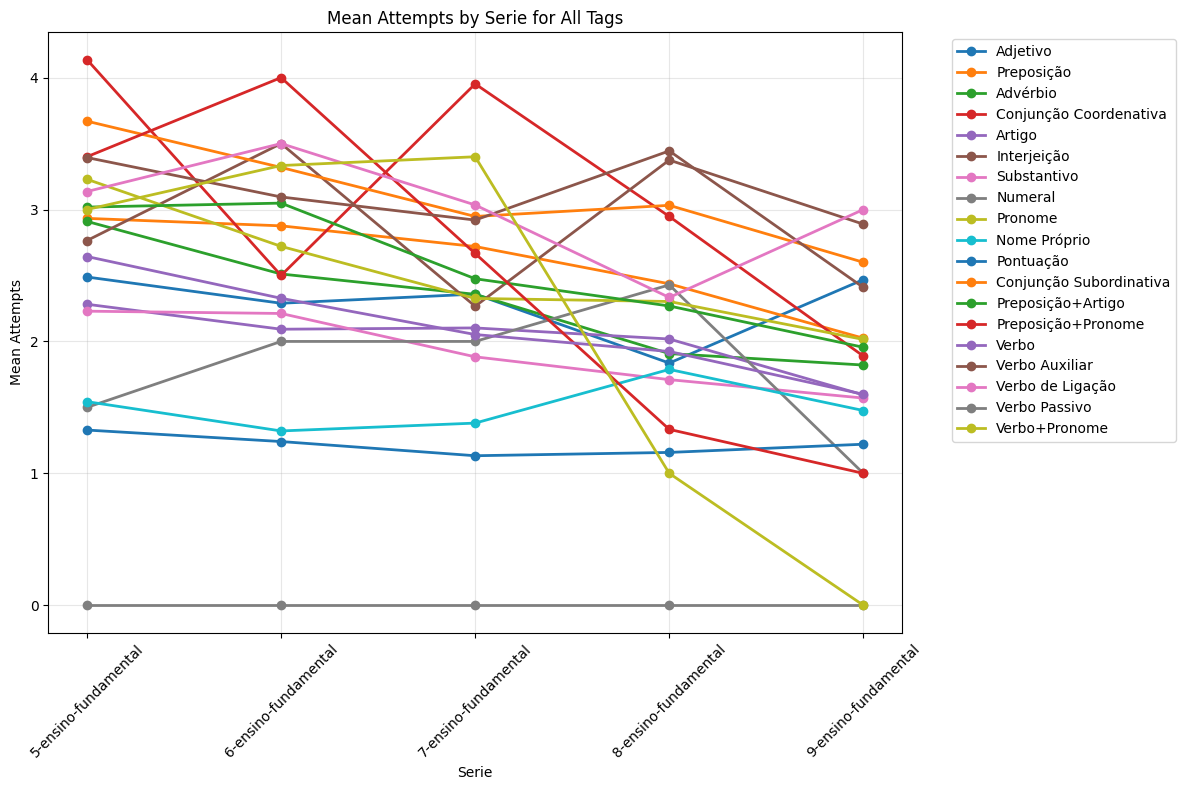

In [98]:
# Get unique tags
unique_tags = stats_df['level_1'].unique()

plt.figure(figsize=(12, 8))

for tag in unique_tags:
    tag_data = stats_df[stats_df['level_1'] == tag][['serie', 'mean_attempts']]
    if not tag_data.empty:
        plt.plot(tag_data['serie'], tag_data['mean_attempts'], marker='o', linewidth=2, markersize=6, label=tag)

plt.xlabel('Serie')
plt.ylabel('Mean Attempts')
plt.title('Mean Attempts by Serie for All Tags')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2205097/3077000626.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(serie_data['level_1'], rotation=45, ha='right')
/tmp/ipykernel_2205097/3077000626.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(serie_data['level_1'], rotation=45, ha='right')
/tmp/ipykernel_2205097/3077000626.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(serie_data['level_1'], rotation=45, ha='right')
/tmp/ipykernel_2205097/3077000626.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(serie_data['level_1'], rotation=45, ha='right')
/tmp/ipykernel_2205097/30770

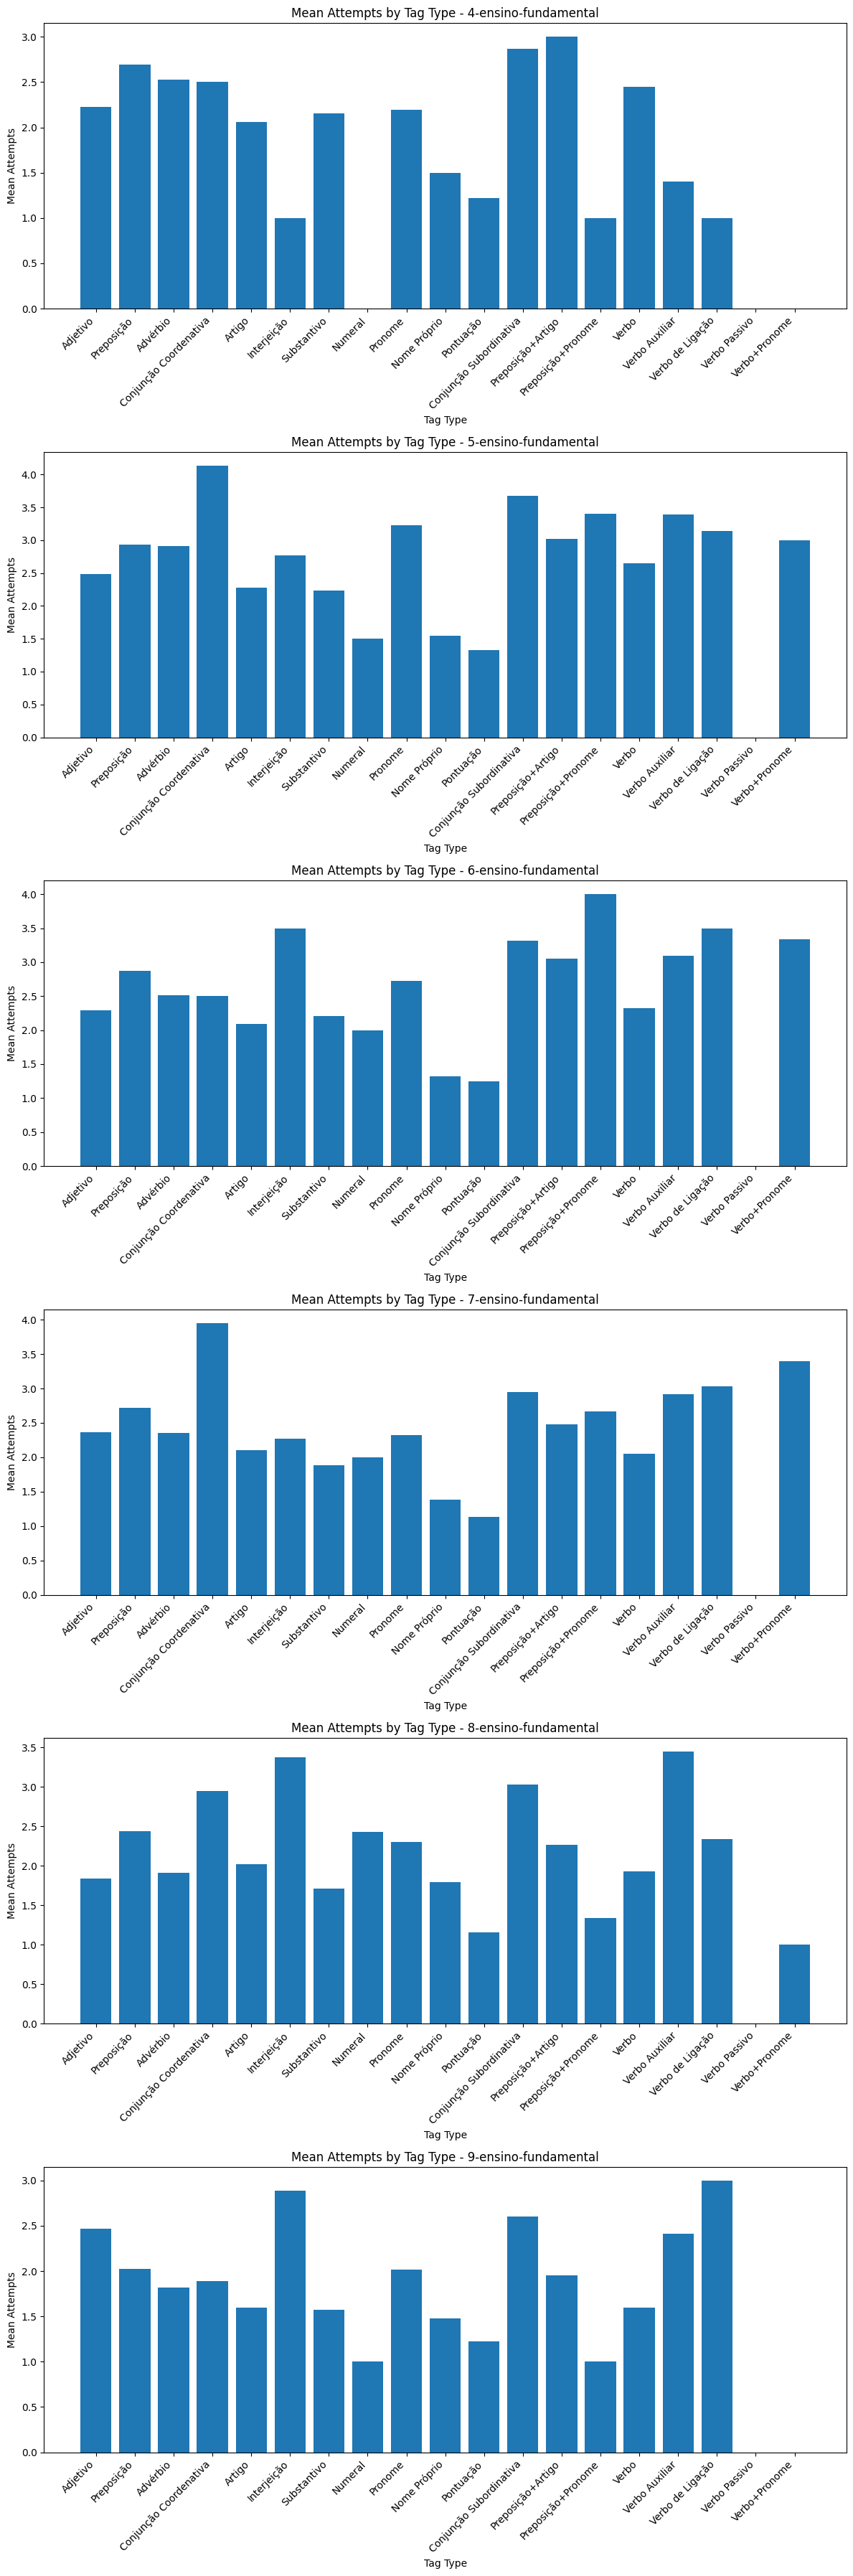

In [56]:
# Get unique series
series_list = stats_df['serie'].unique()

# Create subplots
fig, axes = plt.subplots(len(series_list), 1, figsize=(12, 6 * len(series_list)))

# Handle case where there's only one serie
if len(series_list) == 1:
    axes = [axes]

for i, serie in enumerate(series_list):
    # Filter data for current serie
    serie_data = stats_df[stats_df['serie'] == serie][['level_1', 'mean_attempts']]
    
    # Create bar plot
    axes[i].bar(serie_data['level_1'], serie_data['mean_attempts'])
    axes[i].set_xticklabels(serie_data['level_1'], rotation=45, ha='right')
    axes[i].set_xlabel('Tag Type')
    axes[i].set_ylabel('Mean Attempts')
    axes[i].set_title(f'Mean Attempts by Tag Type - {serie}')

plt.tight_layout()
plt.show()

# Symbolic Test

In [201]:
from sklearn.model_selection import KFold

In [ ]:
rules = {
    'Preposição':{
        3: [5, 6, 7],
        2: [8, 9]
    },
    'Advérbio':{
        3: [5, 6],
        2: [7, 8],
        1: [9]
    },
    'Artigo':{
        2: [5, 6, 7, 8],
        1: [9]
    },
    'Substantivo':{
        2: [5, 6],
        1: [7, 8, 9]
    },
    'Pronome':{
        3: [5, 6],
        2: [7, 8, 9]
    },
    'Conjunção Subordinativa':{
        4: [5],
        3: [6, 7, 8],
        2: [9]
    },
    'Preposição+Artigo':{
        3: [5, 6, 7],
        2: [8, 9]
    },
    'Preposição+Pronome':{
        4: [5, 6],
        3: [7],
        2: [8],
        1: [9]
    },
    'Verbo': {
        3: [5],
        2: [6, 7, 8],
        1: [9]
    }
}

In [188]:
series = {
    5: '5-ensino-fundamental',
    6: '6-ensino-fundamental',
    7: '7-ensino-fundamental',
    8: '8-ensino-fundamental',
    9: '9-ensino-fundamental',
}

assert set(series.values()).issubset(new_session_df['serie'].unique())

In [213]:
df = pd.read_csv('data/interaction_data_250603.csv')

new_session_df = pd.read_csv('data/new_session_data_250603.csv')

def cast_words(words: str) -> List[Word]:
    assert isinstance(words, str), f"Expected str, got {type(words)}"
    words_ = cast(List[Word], eval(words))
    return words_

new_session_df['words'] = new_session_df['words'].apply(cast_words)

new_session_df['words_attempts'] = new_session_df['words'].map(
    lambda word_list: {f"{word['tag']}|{word['word']}|{ULID()}":1 for word in word_list}
)

df = df.merge(new_session_df[['sessionId', 'serie']], on='sessionId', how='inner')
print(f"DataFrame shape after merge: {df.shape}")
df.head(10)

DataFrame shape after merge: (24815, 7)


,correctTag,targetWord,eventType,orderingId,sessionId,draggedTag,serie
0,Verbo,Será,interaction,0,xqEk5ZfKaG,Pronome,5-ensino-fundamental
1,Verbo,Será,interaction,1,xqEk5ZfKaG,Conjunção Subordinativa,5-ensino-fundamental
2,Pontuação,",",interaction,0,uQY36KP907,Pontuação,5-ensino-fundamental
3,Pontuação,!,interaction,1,uQY36KP907,Pontuação,5-ensino-fundamental
4,Substantivo,árvore,interaction,0,X2RK9EgWWZ,Substantivo,6-ensino-fundamental
5,Pontuação,.,interaction,1,X2RK9EgWWZ,Pontuação,6-ensino-fundamental
6,Substantivo,folha,interaction,2,X2RK9EgWWZ,Substantivo,6-ensino-fundamental
7,Verbo,caiu,interaction,3,X2RK9EgWWZ,Verbo,6-ensino-fundamental
8,Artigo,A,interaction,4,X2RK9EgWWZ,Artigo,6-ensino-fundamental
9,Preposição+Artigo,da,interaction,5,X2RK9EgWWZ,Preposição+Artigo,6-ensino-fundamental


In [247]:
SESSION_ID = df['sessionId'].sample().values[0]
SESSION_ID = 'Kfx69nICoG'
print(f"Selected session ID: {SESSION_ID}")
gp = df[df['sessionId'] == SESSION_ID].copy()
gp

Selected session ID: Kfx69nICoG


,correctTag,targetWord,eventType,orderingId,sessionId,draggedTag,serie
1569,Pontuação,.,interaction,0,Kfx69nICoG,Adjetivo,9-ensino-fundamental
1570,Pontuação,.,interaction,1,Kfx69nICoG,Verbo,9-ensino-fundamental
1571,Pontuação,.,interaction,2,Kfx69nICoG,Conjunção Subordinativa,9-ensino-fundamental
1572,Pontuação,.,interaction,3,Kfx69nICoG,Adjetivo,9-ensino-fundamental
1573,Pontuação,.,interaction,4,Kfx69nICoG,Pronome,9-ensino-fundamental
1574,Pontuação,.,interaction,5,Kfx69nICoG,Pontuação,9-ensino-fundamental


In [194]:
def get_counter_dict(gp: pd.DataFrame):
    counter_dict = {
        'Adjetivo': 1,
        'Preposição': 1,
        'Advérbio': 1,
        'Conjunção Coordenativa': 1,
        'Artigo': 1,
        'Interjeição': 1,
        'Substantivo': 1,
        'Numeral': 1,
        'Pronome': 1,
        'Nome Próprio': 1,
        'Pontuação': 1,
        'Conjunção Subordinativa': 1,
        'Preposição+Artigo': 1,
        'Preposição+Pronome': 1,
        'Verbo': 1,
        'Verbo Auxiliar': 1,
        'Verbo de Ligação': 1,
        'Verbo Passivo': 1,
        'Verbo+Pronome': 1,
    }

    id_aux = -1
    for _, row in gp[['orderingId', 'correctTag', 'draggedTag']].iterrows():
        assert (id_aux := id_aux + 1) < row['orderingId']+1
        correctTag, draggedTag = row['correctTag'], row['draggedTag']
        if correctTag != draggedTag:
            counter_dict[correctTag] += 1

    correctTag_unique = gp['correctTag'].unique()
    for k, v in counter_dict.items():
        if k not in correctTag_unique:
            counter_dict[k] = 0

    counter_dict_filtered = {k:counter_dict[k] for k in rules.keys()}
    counter_dict_filtered = {k: v for k, v in counter_dict_filtered.items() if v != 0}
    return counter_dict_filtered

In [189]:
def get_serie_by_attempts(attempts: dict):
    guess_serie = []
    series = {
        5: '5-ensino-fundamental',
        6: '6-ensino-fundamental',
        7: '7-ensino-fundamental',
        8: '8-ensino-fundamental',
        9: '9-ensino-fundamental',
    }

    for ud, n_attempts in attempts.items():
        match ud:
            case 'Preposição':
                if n_attempts >= 3:
                    guess_serie += [5, 6, 7]
                elif n_attempts <= 2 and n_attempts >= 1:
                    guess_serie += [8, 9]
            case 'Advérbio':
                if n_attempts >= 3:
                    guess_serie += [5, 6]
                elif n_attempts == 2:
                    guess_serie += [7, 8]
                elif n_attempts == 1:
                    guess_serie += [9]
            case 'Artigo':
                if n_attempts >= 2:
                    guess_serie += [5, 6, 7, 8]
                elif n_attempts == 1:
                    guess_serie += [9]
            case 'Substantivo':
                if n_attempts >= 2:
                    guess_serie += [5, 6]
                elif n_attempts == 1:
                    guess_serie += [7, 8, 9]
            case 'Pronome':
                if n_attempts >= 3:
                    guess_serie += [5, 6]
                elif n_attempts <= 2 and n_attempts >= 1:
                    guess_serie += [7, 8, 9]
            case 'Conjunção Subordinativa':
                if n_attempts >= 4:
                    guess_serie += [5]
                elif n_attempts == 3:
                    guess_serie += [6, 7, 8]
                elif n_attempts <= 2 and n_attempts >= 1:
                    guess_serie += [9]
            case 'Preposição+Artigo':
                if n_attempts >= 3:
                    guess_serie += [5, 6, 7]
                elif n_attempts <= 2 and n_attempts >= 1:
                    guess_serie += [8, 9]
            case 'Preposição+Pronome':
                if n_attempts >= 4:
                    guess_serie += [5, 6]
                elif n_attempts == 3:
                    guess_serie += [7]
                elif n_attempts == 2:
                    guess_serie += [8]
                elif n_attempts == 1:
                    guess_serie += [9]
            case 'Verbo':
                if n_attempts >= 3:
                    guess_serie += [5]
                elif n_attempts == 2:
                    guess_serie += [6, 7, 8]
                elif n_attempts == 1:
                    guess_serie += [9]
            case _:
                continue
        # print(guess_serie)

    return series[int(stats.mode(guess_serie)[0])]

In [215]:
get_serie_by_attempts(get_counter_dict(gp))

'5-ensino-fundamental'

As que deram erro são **sessões não completas**, ou seja, o aluno desistou pela metade.

In [242]:
hits = 0
session_ids_erros = []

for _, row in df.groupby('sessionId')['serie'].first().reset_index().iterrows():
    sessionId, serie = row['sessionId'], row['serie']
    gp = df[df['sessionId'] == sessionId].copy()
    try:
        predict_serie = get_serie_by_attempts(get_counter_dict(gp))
    except Exception as e:
        session_ids_erros.append(sessionId)
        # print(f"Error processing session {sessionId}: {e}")
        continue
    if predict_serie == serie:
        hits += 1

print(f"Total hits: {hits} out of {len(df['sessionId'].unique())} sessions")

/tmp/ipykernel_2205097/2811787581.py:72: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return series[int(stats.mode(guess_serie)[0])]
/tmp/ipykernel_2205097/2811787581.py:72: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return series[int(stats.mode(guess_serie)[0])]
/tmp/ipykernel_2205097/2811787581.py:72: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return series[int(stats.mode(guess_serie)[0])]
/tmp/ipykernel_2205097/2811787581.py:72: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return series[int(stats.mode(guess_serie)[0])]
/tmp/ipykernel_2205097/2811787581.py:72: SmallSampleWarning: One

Total hits: 332 out of 1431 sessions


In [251]:
round(332/1431,4)*100

23.200000000000003

In [236]:
skf = KFold(n_splits=2, shuffle=True, random_state=42)
X = df.groupby('sessionId')['serie'].first().reset_index()['sessionId'].values
y = df.groupby('sessionId')['serie'].first().reset_index()['serie'].values

for train_index, test_index in skf.split(X, y):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    print(f"Train: {X_train}, Test: {X_test}")
    print(f"Train labels: {y_train}, Test labels: {y_test}")
    print("-" * 40)
    break

Train: ['-3Q1xJXqzA' '-6gZ-mHdzv' '-FzZZhJbxP' '-KKoI3T16q' '-LK6a0x4ai'
 '-O_7b3hTjn' '-RqVl0A0z4' '-W680F8PID' '-asjPSbWD9' '-eKAHtInxz'
 '-mAf-y7PqL' '-mCGj_B5uu' '-tliuno7P0' '-z15Z4-2KZ' '03S3VQACiP'
 '03ffsV7MFm' '07lP0tkHNF' '08DL_loZg1' '0FUlHxYk7T' '0H7RucbwUC'
 '0X2gkzunMt' '0aP1icACs-' '0aVYBXVbQD' '0elJbLsRpB' '0fFhqEGCle'
 '0mkioD5umT' '0n83PpKlVk' '0rTTRBLQkf' '1IEWDDp88P' '1QZahJdR9n'
 '1XM6T9hQ3a' '1hXwEdBe7v' '22JYr4631c' '24a0ePVbLW' '28-pzdf8t9'
 '2PdyZ2iyi7' '2Qwu-OVPp0' '2jAE7E8MgW' '2mgFdHLfN4' '2qUPa7P3qf'
 '34otyBcwgH' '3Ev5wtAJFe' '3JEnk1lXM7' '3JX_iIv1Ms' '3RRLpfBHJo'
 '3XDwRV1ZDz' '3iZO9CPeEv' '3nykisM1ul' '3uav98HqXU' '3z1HFRsMdR'
 '45G1ZLuysH' '4A3YWaqMVV' '4Bwtk5vc5_' '4EgS_xPUEl' '4IYZpFYQla'
 '4acuXEXfYH' '4e4SBiyKUs' '4eetduOre-' '4lEgxQktj4' '4liEqxGbgV'
 '4zU1hox2-7' '5-Ah4988p6' '58Q8wGWW5R' '58x4TG70Xa' '5BeMBkAi92'
 '5cv-hiMK11' '5fHVUpp6nI' '5iHqHbCTJ9' '5ijDJFBB--' '5lYvInQuGc'
 '5wQxLZFzww' '5zrwmlDeoz' '63jt4x8nhq' '68ANMvWNUK' '6F_Mu-4Itw'
 '6

In [ ]:
k = 5
skf = KFold(n_splits=k, shuffle=True, random_state=42)

X = df['input'].values
y = df['serie'].values
num_labels = df['label'].nunique()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n==== Fold {fold + 1}/{k} ====")
    
    # Divide os dados
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df = df.iloc[test_idx].reset_index(drop=True)

In [ ]:
k = 5
skf = KFold(n_splits=k, shuffle=True, random_state=42)

X = df['input'].values
y = df['serie'].values
num_labels = df['label'].nunique()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n==== Fold {fold + 1}/{k} ====")
    
    # Divide os dados
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df = df.iloc[test_idx].reset_index(drop=True)

In [136]:
gp[['orderingId', 'correctTag', 'draggedTag']]

,orderingId,correctTag,draggedTag
4445,0,Pontuação,Verbo
4454,1,Pontuação,Pontuação
4457,2,Verbo,Verbo
4459,3,Advérbio,Advérbio
4463,4,Preposição+Artigo,Substantivo
4465,5,Preposição+Artigo,Artigo
4467,6,Preposição+Artigo,Substantivo
4470,7,Preposição+Artigo,Preposição+Artigo
4474,8,Substantivo,Substantivo
4479,9,Artigo,Artigo


Series Prediction Formula
For a given part-of-speech tag $t$ with number of attempts $n$, the predicted series set $S(t,n)$ is defined as:

$$S(t,n) = \begin{cases} {5,6,7} & \text{if } t = \text{Preposição} \land n \geq 3 \ {8,9} & \text{if } t = \text{Preposição} \land 1 \leq n \leq 2 \ \ {5,6} & \text{if } t = \text{Advérbio} \land n \geq 3 \ {7,8} & \text{if } t = \text{Advérbio} \land n = 2 \ {9} & \text{if } t = \text{Advérbio} \land n = 1 \ \ {5,6,7,8} & \text{if } t = \text{Artigo} \land n \geq 2 \ {9} & \text{if } t = \text{Artigo} \land n = 1 \ \ {5,6} & \text{if } t = \text{Substantivo} \land n \geq 2 \ {7,8,9} & \text{if } t = \text{Substantivo} \land n = 1 \ \ {5,6} & \text{if } t = \text{Pronome} \land n \geq 3 \ {7,8,9} & \text{if } t = \text{Pronome} \land 1 \leq n \leq 2 \ \ {5} & \text{if } t = \text{Conjunção Subordinativa} \land n \geq 4 \ {6,7,8} & \text{if } t = \text{Conjunção Subordinativa} \land n = 3 \ {9} & \text{if } t = \text{Conjunção Subordinativa} \land 1 \leq n \leq 2 \ \ {5,6,7} & \text{if } t = \text{Preposição+Artigo} \land n \geq 3 \ {8,9} & \text{if } t = \text{Preposição+Artigo} \land 1 \leq n \leq 2 \ \ {5,6} & \text{if } t = \text{Preposição+Pronome} \land n \geq 4 \ {7} & \text{if } t = \text{Preposição+Pronome} \land n = 3 \ {8} & \text{if } t = \text{Preposição+Pronome} \land n = 2 \ {9} & \text{if } t = \text{Preposição+Pronome} \land n = 1 \ \ {5} & \text{if } t = \text{Verbo} \land n \geq 3 \ {6,7,8} & \text{if } t = \text{Verbo} \land n = 2 \ {9} & \text{if } t = \text{Verbo} \land n = 1 \ \ \emptyset & \text{otherwise} \end{cases}$$

The final prediction for a session with multiple tags is: $$\text{PredictedSeries} = \bigcup_{i} S(t_i, n_i)$$

where $t_i$ and $n_i$ are the tag type and number of attempts for each word type $i$ in the session.